# Training and Inference Code for Multi-Instance Object Detection

## For visualizations of the detection outputs, scroll to the end of the notebook.


In [1]:
!git clone https://github.com/pyrylss/DINO.git
%cd DINO

Cloning into 'DINO'...
remote: Enumerating objects: 503, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 503 (delta 176), reused 147 (delta 126), pack-reused 250 (from 1)
Receiving objects: 100% (503/503), 13.44 MiB | 30.52 MiB/s, done.
Resolving deltas: 100% (230/230), done.
/kaggle/working/DINO


In [2]:
#import sys
#sys.path.append("/kaggle/working/DINO/models/dino/ops")

In [3]:
!pip install -q addict
!pip install -q yapf
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.1 MB/s eta 0:00:00


In [4]:
!cd /kaggle/working/DINO/models/dino/ops && python setup.py build install -q

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Emitting ninja build file /kaggle/working/DINO/models/dino/ops/build/temp.linux-x86_64-cpython-311/build.ninja...
Compiling objec

In [5]:
import os
import json
from pathlib import Path
from PIL import Image, ImageDraw
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from util.slconfig import SLConfig
from main import build_model_main
from util import box_ops
import datasets.transforms as T

In [6]:
#!cd /kaggle/working/DINO/models/dino/ops && python test.py

In [7]:
!wget https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22k.pth

--2025-07-28 16:40:07--  https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22k.pth
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/357198522/6c765b00-9bd4-11eb-8f17-e28fbfaad866?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-07-28T17%3A16%3A11Z&rscd=attachment%3B+filename%3Dswin_large_patch4_window12_384_22k.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-07-28T16%3A15%3A27Z&ske=2025-07-28T17%3A16%3A11Z&sks=b&skv=2018-11-09&sig=EuzXM3fi2jy9NfWpLOcwhZHUOw9cOpzqlnEN81DEWUE%3D&jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1MzcyMTEwNywibmJmIjoxNzUzNzIw

In [8]:
backbone = '/kaggle/working/DINO/swin_large_patch4_window12_384_22k.pth'
train_images_path = '/kaggle/input/synthetic-tomato/Output/2025-06-27-19-02-23/train/images'
train_labels_path = '/kaggle/input/synthetic-tomato/Output/2025-06-27-19-02-23/train/labels'

val_images_path = '/kaggle/input/synthetic-tomato/Output/2025-06-27-19-02-23/val/images'
val_labels_path = '/kaggle/input/synthetic-tomato/Output/2025-06-27-19-02-23/val/labels'

classes = ["Soup"]

# Convert data to be suitable for DINO

In [9]:
for data_split in ["train", "val"]:
    base_path = Path(f"/kaggle/input/synthetic-tomato/output/Output/2025-06-27-19-02-23/{data_split}")
    base_path2 = Path(f"/kaggle/input/synthetic-tomato/2025-07-09-09-46-03/2025-07-09-09-46-03/{data_split}")
    base_path3 = Path(f"/kaggle/input/synthetic-tomato/2025-07-09-09-26-27/2025-07-09-09-26-27/{data_split}")

    base_path4 = Path(f"/kaggle/input/synthetic-tomato/2025-07-11-10-34-27/2025-07-11-10-34-27/{data_split}")
    base_path5 = Path(f"/kaggle/input/synthetic-tomato/2025-07-11-10-47-17/2025-07-11-10-47-17/{data_split}")

    output_json = Path(f"/kaggle/working/annotations/instances_{data_split}2017.json")
    
    classes = ["Soup"]  # class list
    # Create COCO-style structure
    coco_dict = {
        "info": {},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": [{"id": i, "name": name} for i, name in enumerate(classes)]
    }
    
    annotation_id = 0
    image_id = 0

    bases = [base_path, base_path2, base_path3, base_path4, base_path5]
    for base_path in bases:
        image_dir = base_path / "images"
        label_dir = base_path / "labels"
        
        output_json.parent.mkdir(parents=True, exist_ok=True)
        
        for image_path in sorted(image_dir.glob("*.png")):
            img = Image.open(image_path)
            width, height = img.size

            new_filename = f"{image_id}.png"
            #Copy image to target directory
            target_image_dir = Path(f"/kaggle/working/{data_split}2017")
            target_image_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy(image_path, target_image_dir / new_filename)
        
            # Add image entry
            coco_dict["images"].append({
                "file_name": new_filename,
                "height": height,
                "width": width,
                "id": image_id,
            })

        
            # Corresponding label file
            label_path = label_dir / (image_path.stem + ".txt")
            
            if label_path.exists():
                with open(label_path) as f:
                    for line in f:
                        class_id, xc, yc, w, h = map(float, line.strip().split())
        
                        # Convert to top-left format
                        x = (xc - w / 2) * width
                        y = (yc - h / 2) * height
                        box_w = w * width
                        box_h = h * height
        
                        coco_dict["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": int(class_id),
                            "bbox": [x, y, box_w, box_h],
                            "area": box_w * box_h,
                            "iscrowd": 0
                        })
                        annotation_id += 1
        
            image_id += 1
        
    #save
    with open(output_json, "w") as f:
        json.dump(coco_dict, f)
    
    print(f"JSON saved to: {output_json}")


JSON saved to: /kaggle/working/annotations/instances_train2017.json
JSON saved to: /kaggle/working/annotations/instances_val2017.json


In [10]:
# Create target directories
!mkdir -p /kaggle/working/train2017
!mkdir -p /kaggle/working/val2017

# List of train image folders
!cp /kaggle/input/synthetic-tomato/output/Output/2025-06-27-19-02-23/train/images/* /kaggle/working/train2017/
!cp /kaggle/input/synthetic-tomato/2025-07-09-09-46-03/2025-07-09-09-46-03/train/images/* /kaggle/working/train2017/
!cp /kaggle/input/synthetic-tomato/2025-07-09-09-26-27/2025-07-09-09-26-27/train/images/* /kaggle/working/train2017/

!cp /kaggle/input/synthetic-tomato/2025-07-11-10-34-27/2025-07-11-10-34-27/train/images/* /kaggle/working/train2017/
!cp /kaggle/input/synthetic-tomato/2025-07-11-10-47-17/2025-07-11-10-47-17/train/images/* /kaggle/working/train2017/


# List of val image folders
!cp /kaggle/input/synthetic-tomato/output/Output/2025-06-27-19-02-23/val/images/* /kaggle/working/val2017/
!cp /kaggle/input/synthetic-tomato/2025-07-09-09-46-03/2025-07-09-09-46-03/val/images/* /kaggle/working/val2017/
!cp /kaggle/input/synthetic-tomato/2025-07-09-09-26-27/2025-07-09-09-26-27/val/images/* /kaggle/working/val2017/

!cp /kaggle/input/synthetic-tomato/2025-07-11-10-34-27/2025-07-11-10-34-27/val/images/* /kaggle/working/val2017/
!cp /kaggle/input/synthetic-tomato/2025-07-11-10-47-17/2025-07-11-10-47-17/val/images/* /kaggle/working/val2017/


In [11]:
!sed -i 's/np\.float/float/g' /usr/local/lib/python3.11/dist-packages/pycocotools/cocoeval.py


In [12]:
import gdown

file_id = "14h4UCi-HsDL01ZQRbpV47dzMST_py_vM"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="model.pth", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=14h4UCi-HsDL01ZQRbpV47dzMST_py_vM
From (redirected): https://drive.google.com/uc?id=14h4UCi-HsDL01ZQRbpV47dzMST_py_vM&confirm=t&uuid=a773a9d9-0c09-4987-94be-ed323b49d925
To: /kaggle/working/DINO/model.pth
100%|██████████| 2.62G/2.62G [00:19<00:00, 137MB/s]


'model.pth'

# Training

In [13]:
## RUN TRAINING
!python /kaggle/working/DINO/main.py \
    --output_dir logs/DINO/R50-MS4 \
    --pretrain_model_path /kaggle/working/DINO/model.pth \
    --finetune_ignore label_enc.weight class_embed \
    -c config/DINO/DINO_5scale_swin.py \
    --coco_path /kaggle/working \
    --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0 backbone_dir=/kaggle/working/DINO


Not using distributed mode
Loading config file from config/DINO/DINO_5scale_swin.py
[07/28 16:41:20.939]: git:
  sha: dd6806b4ae2d470a90087b9b14e3c703646bfa30, status: clean, branch: main

[07/28 16:41:20.939]: Command: /kaggle/working/DINO/main.py --output_dir logs/DINO/R50-MS4 --pretrain_model_path /kaggle/working/DINO/model.pth --finetune_ignore label_enc.weight class_embed -c config/DINO/DINO_5scale_swin.py --coco_path /kaggle/working --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0 backbone_dir=/kaggle/working/DINO
[07/28 16:41:20.940]: Full config saved to logs/DINO/R50-MS4/config_args_all.json
[07/28 16:41:20.940]: world size: 1
[07/28 16:41:20.940]: rank: 0
[07/28 16:41:20.940]: local_rank: 0
[07/28 16:41:20.940]: args: Namespace(config_file='config/DINO/DINO_5scale_swin.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0,

In [14]:
import sys
sys.path.append("/kaggle/working/DINO/models/dino/ops")

In [15]:
!cd /kaggle/working/DINO/models/dino/ops && python setup.py build_ext --inplace

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Emitting ninja build file /kaggle/working/DINO/models/dino/ops/build/temp.linux-x86_64-cpython-311/build.ninja...
Compiling objec

# Inference and visualisations

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


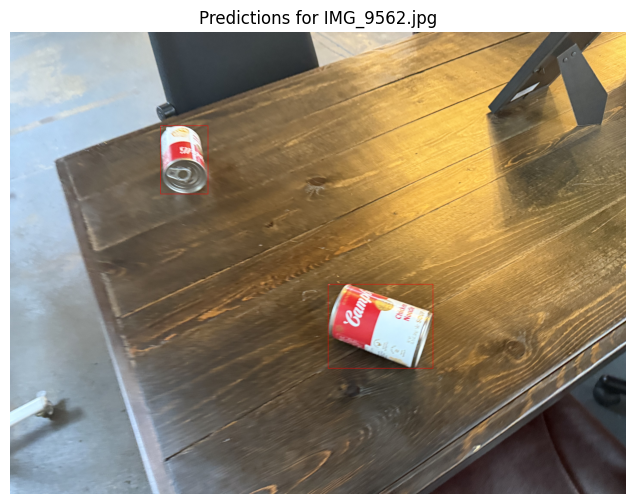

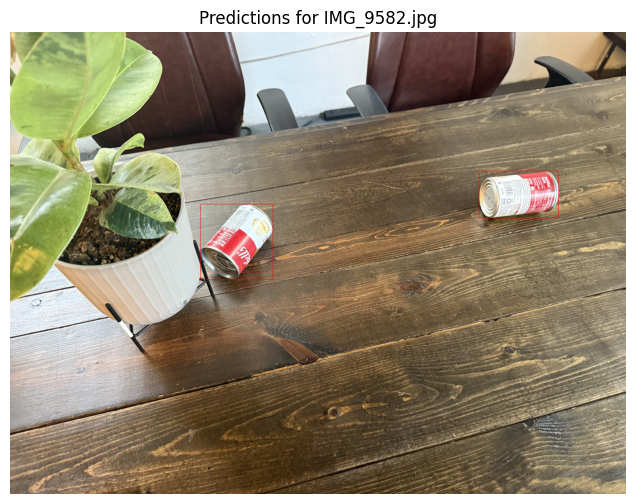

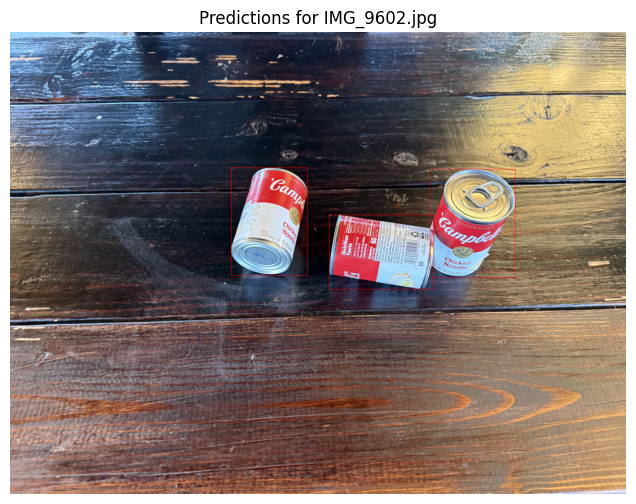

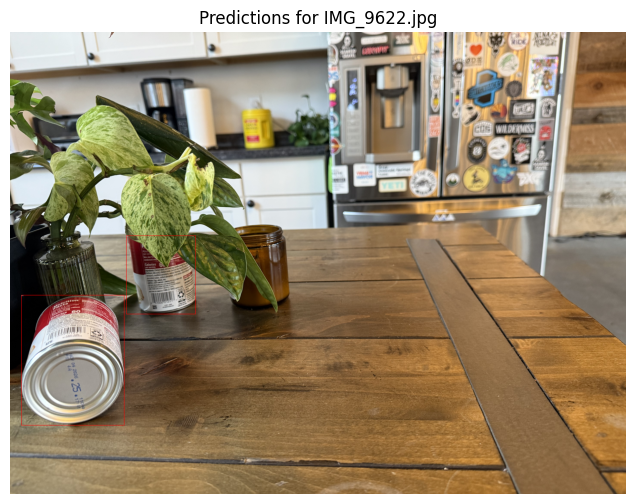

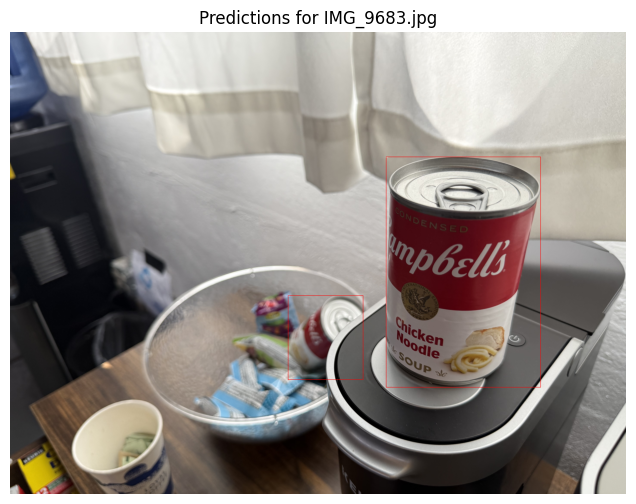

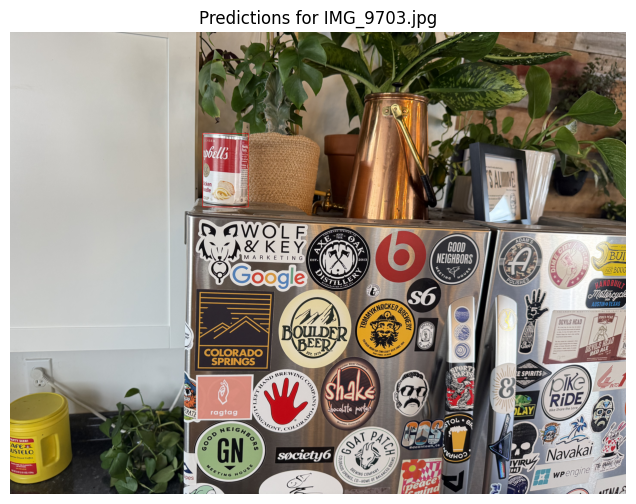

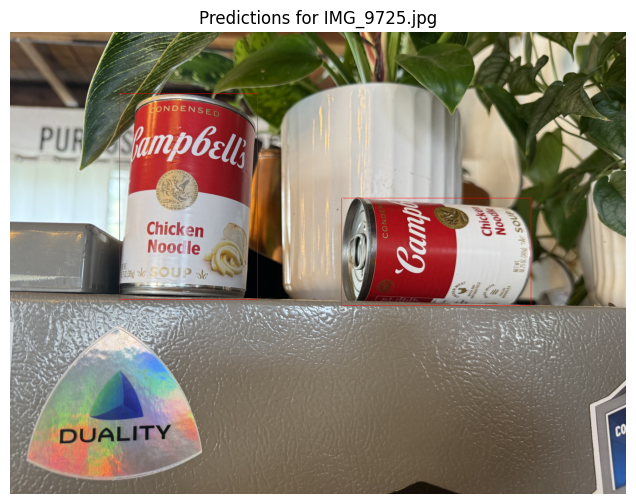

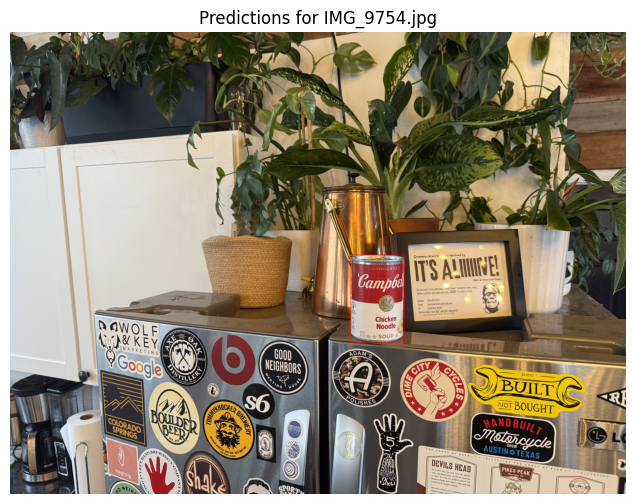

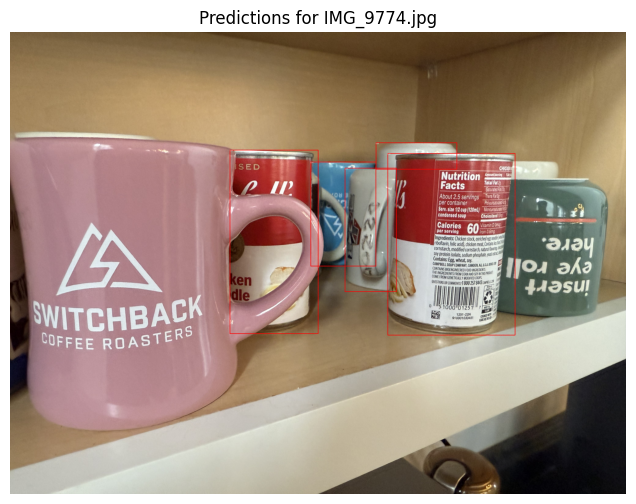

Submission saved to 'submission.csv'


In [16]:
# Load model
config_path = "/kaggle/working/DINO/config/DINO/DINO_5scale_swin.py"
checkpoint_path = "/kaggle/working/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth"

args = SLConfig.fromfile(config_path)
args.device = 'cuda'
model, _, postprocessors = build_model_main(args)
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint["model"])
model.cuda().eval()


# Define transform
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Inference + Visualization
test_dir = "/kaggle/input/multi-instance-object-detection-challenge/Starter_Dataset/TestImages/images"
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])
submission_data = []

threshold = 0.3  # confidence threshold
visualize_every = 20  # visualize every N images

for idx, fname in enumerate(test_images):
    image_id = os.path.splitext(fname)[0]
    img_path = os.path.join(test_dir, fname)
    image = Image.open(img_path).convert("RGB")
    w, h = image.size

    img_tensor, _ = transform(image, None)
    img_tensor = img_tensor.cuda()

    with torch.no_grad():
        output = model(img_tensor[None])
        output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

    scores = output['scores']
    boxes = output['boxes']
    keep = scores > threshold

    pred_str_parts = []
    draw = ImageDraw.Draw(image)
    
    for score, box in zip(scores[keep], boxes[keep]):
        x1, y1, x2, y2 = box.tolist()
        x_center = ((x1 + x2) / 2)
        y_center = ((y1 + y2) / 2)
        width = (x2 - x1)
        height = (y2 - y1)

        # Append to CSV predictions
        pred_str_parts.append(f"0 {score:.6f} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Draw box on image
        x1 *= w
        x2 *= w
        y1 *= h
        y2 *= h

        draw.rectangle([x1, y1, x2, y2], outline="red", width=4)
        draw.text((x1, y1), f"{score:.2f}", fill="white")

    prediction_string = " ".join(pred_str_parts)
    submission_data.append({"image_id": image_id, "prediction_string": prediction_string})

    # Visualize every Nth image
    if idx % visualize_every == 0:
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Predictions for {fname}")
        plt.show()


# Save predictions to a file
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv("submission.csv", index=False)
print("Submission saved to 'submission.csv'")

